# Machine Learning Engineer Nanodegree - 2019
## Capstone Project: Movie Box Office Revenue Prediction with Gradient Boosting Models
Author: Daniel Tejeda

In a world where movies made an estimated 41.7 billion in 2018 and expected to go over 50 billion by 2020, the film industry is more popular than ever. But which movies make the most money at the box office? How much does a director or the budget matter? In this capstone project, I will build a model to answer that question, working with metadata on over 7,000 past films from The Movie Database published as part of TMDB Box Office Prediction Kaggle competition. 


### Project Design

This project will be implemented in Python 3.7. Libraries involved will be numpy, pandas, matplotlib, seaborn, xgboost, lightgbm, catboost, scikit-learn.

The workflow for this project will be in the following order: 
0. Import all libraries
- Exploratory data analysis
- Data cleansing and Feature engineering
- Train the KNN benchmark model based on budget, popularity and runtime
- Stage-1: Boosting Models 
    * Code and train XGBoost model 
    * Code and train CATBoost model
    * Code and train LightGBM model
    * Hyperparameter tuning for the three models
    * Evaluate results against KNN and select new benchmark from the boosting models to be the new benchmark.
    
- Stage 2: Stacked final model
    * Select stacking approach and regression algorithm for the final model
    * Train regression algorithm with the outputs of the base boosting models combined with the original features, according to the stacking approach
    * Hyperparameter tuning for the final model
    * Evaluate and report final results against the benchmark 



## 0. Import all libraries

In [208]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

#import visuals as vs
import data_prep as dp
import json
from itertools import cycle, islice
from datetime import datetime

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn import cluster

import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import copy



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Exploratory data analysis

In [209]:
#dataset_names = ['train','test']

# load original datasets
original_datasets = { ds : pd.read_csv("data/{}.csv".format(ds)) for ds in dataset_names }

# complete missing budget/revenue values from B H's Kernel. (https://www.kaggle.com/zero92/tmdb-prediction)
dp.complete_missing_data(original_datasets)

original_datasets['train'].head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [210]:
n_records = original_datasets['train'].shape[0]
n_columns = original_datasets['train'].shape[1]

print("Total number of records: {}".format(n_records))
print("Total number of features: {}".format(n_columns))

Total number of records: 3000
Total number of features: 23


In [211]:
original_datasets['train'].describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0090060,en,Alone in the Dark,A team of U.S. government agents is sent to in...,NaN,...,9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Fantastic Four,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5351894ec3a3681d980018a8', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.266135e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.668176e+07
std,866.169729,NaN,3.702662e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375149e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.401550e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,3.000000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.877599e+07


Some fields contain list with dictionaries. We will need to extract and transform these features. 

 

### Missing values

In [212]:
original_datasets['train'].isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

### Distribution of target variable Revenue
Let's take a look at the target variable revenue and how its distributed. We are also plotting the Log1p, since we are going to use this in out model

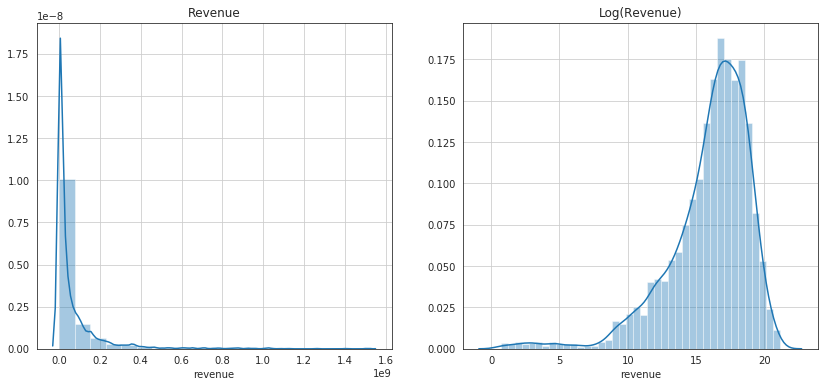

In [213]:
quant_data = original_datasets['train'].set_index('id')[['budget','popularity','runtime', 'revenue']]
quant_data['log_revenue'] = np.log1p(quant_data['revenue'])

sb.set_style("white")

fig, axes = plt.subplots(1, 2, figsize = (14,6))

sb.distplot(quant_data['revenue'], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Revenue")
sb.distplot(np.log1p(quant_data['revenue']), bins=40, kde=True, ax=axes[1])
axes[1].set_title("Log(Revenue)")

for ax in axes: ax.grid()
    

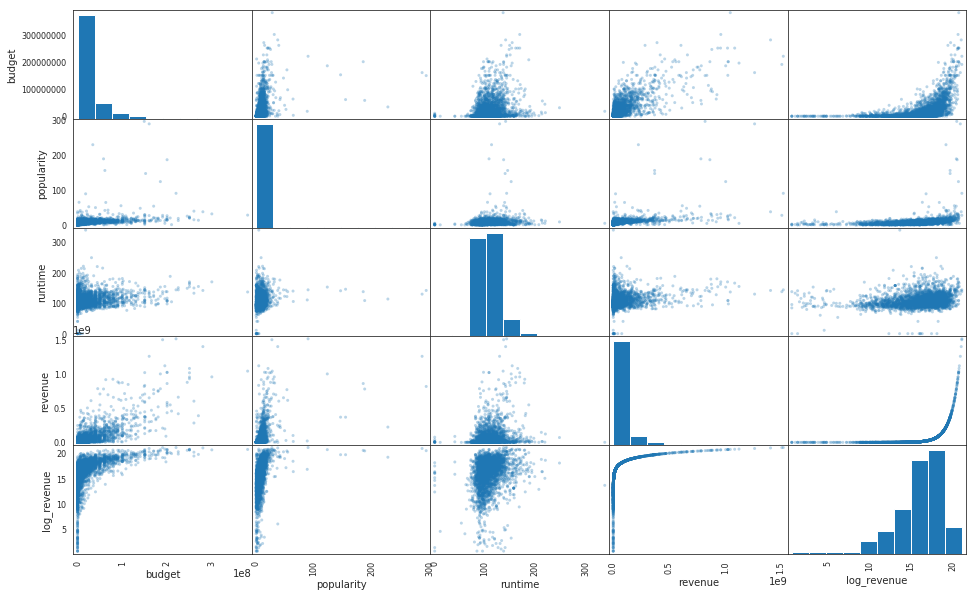

In [214]:
# scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(quant_data, alpha = 0.3, figsize = (16,10));

## 2. Data cleansing and feature engineering

In [215]:
# copy the original dataset and replace NaN with empty string
all_data = original_datasets['train'].set_index('id')

In [216]:
def data_prep_clean_na(data):
    # two movies have NaN runtime, we fill those with the mean
    data['runtime'].fillna(data['runtime'].mean(), inplace=True)

    # replace NaN in strings
    data.fillna('', inplace=True)

data_prep_clean_na(all_data)

In [217]:
def data_prep_dates(data):
    #let's break down month/day/year from release_date
    data[['rel_month','rel_day','rel_year']] = data['release_date'].str.split('/', expand=True).astype(int)

    # fix 2-digit year for 1920-1999
    data['rel_year'] += 1900
    # 2000-2019
    data.loc[data['rel_year'] <= 1919, "rel_year"] += 100

    # extract day of week and quarter
    rel_date = pd.to_datetime(data['release_date']) 
    data['rel_dow'] = rel_date.dt.dayofweek
    data['rel_quarter'] = rel_date.dt.quarter

    
data_prep_dates(all_data)
all_data[['rel_month','rel_day','rel_year','rel_dow','rel_quarter']].head(3)

,rel_month,rel_day,rel_year,rel_dow,rel_quarter
id,,,,,
1,2,20,2015,4,1
2,8,6,2004,4,3
3,10,10,2014,4,4


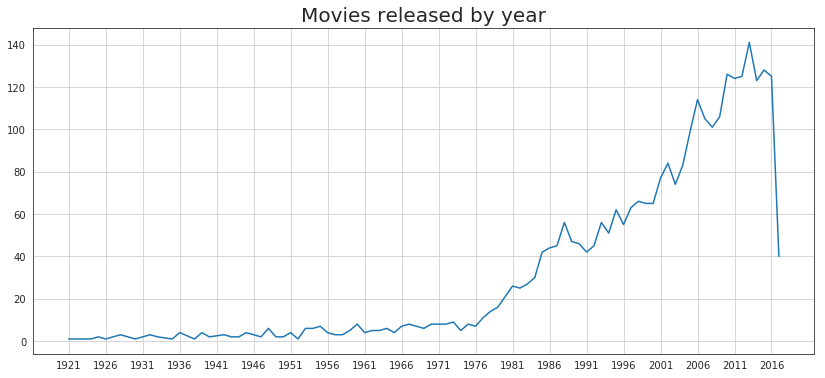

In [218]:
yr_counts = all_data['rel_year'].value_counts().sort_index()
yr_xticks = range(yr_counts.index.values[0],yr_counts.index.values[-1],5)

plt.figure(figsize = (14,6))
plt.plot(yr_counts.index.values, yr_counts.values)
plt.xticks(yr_xticks)
plt.title("Movies released by year",fontsize=20)
plt.grid()

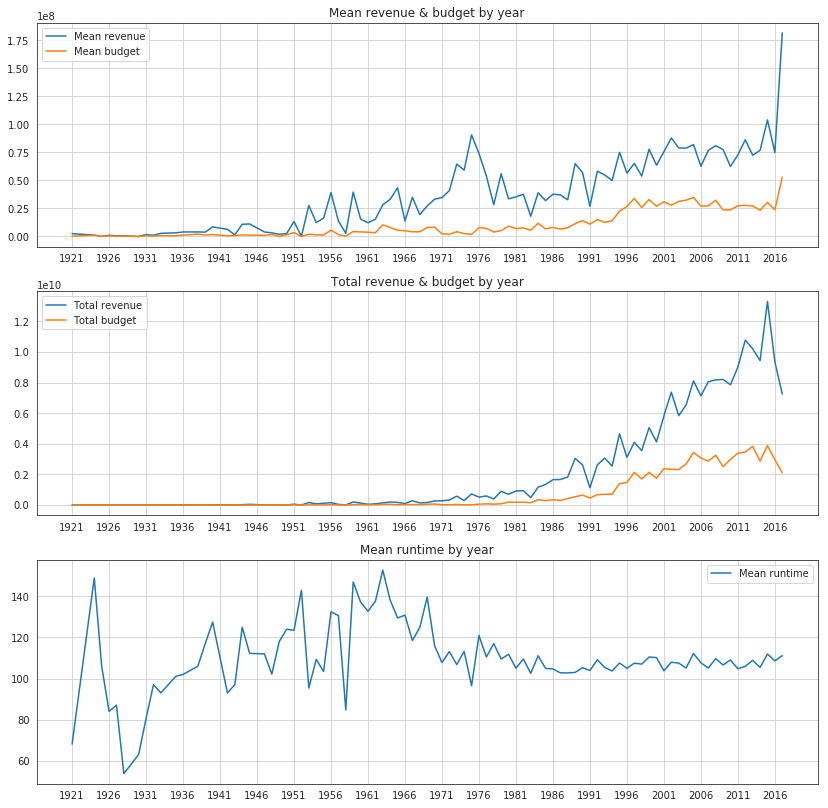

In [219]:
yr_avgs = all_data.groupby('rel_year').mean()
yr_totals = all_data.groupby('rel_year').sum()

fig, axes = plt.subplots(3, 1, figsize=(14,14))

axes[0].set_title("Mean revenue & budget by year")
axes[0].plot(yr_avgs.index.values, yr_avgs['revenue'], label='Mean revenue')
axes[0].plot(yr_avgs.index.values, yr_avgs['budget'], label='Mean budget')
axes[0].set_xticks(yr_xticks)

axes[1].set_title("Total revenue & budget by year")
axes[1].plot(yr_totals.index.values, yr_totals['revenue'], label='Total revenue')
axes[1].plot(yr_totals.index.values, yr_totals['budget'], label='Total budget')
axes[1].set_xticks(yr_xticks)

axes[2].set_title("Mean runtime by year")
axes[2].plot(yr_avgs.index.values, yr_avgs['runtime'], label='Mean runtime')
axes[2].set_xticks(yr_xticks)

for ax in axes: 
    ax.grid()
    ax.legend()

In [220]:
def data_prep_collection(data, mincount=3):

    # belongs_to_collection
    data['from_collection'] = data['belongs_to_collection'].apply(lambda x: 1 if len(x) > 0 else 0)

    data['collection_name'] = data['belongs_to_collection'].map(lambda x: 'col_{}'.format(dp.get_dictionary(x)[0]['name']) if len(x) > 0 else '')

    collection_names = data['collection_name'].str.translate({ord(i): None for i in '[]<'}).str.get_dummies()
    
    cols = list(collection_names.sum()[collection_names.sum() >= mincount].index)
    
    data[cols] = collection_names[cols]
    
    return cols
    
encoded_cols = data_prep_collection(all_data)
print("Movies that belong to a collection: {} / {}".format(sum(all_data['from_collection']), n_records))
print('{} collection columns added'.format(len(encoded_cols)))
all_data[encoded_cols].rename(lambda x:x[4:], axis='columns').sum().sort_values(ascending=False)

Movies that belong to a collection: 604 / 3000
33 collection columns added


James Bond Collection                        16
Friday the 13th Collection                    7
The Pink Panther (Original) Collection        6
Police Academy Collection                     5
Pokémon Collection                            5
Resident Evil Collection                      4
Alien Collection                              4
Child's Play Collection                       4
Ice Age Collection                            4
Paranormal Activity Collection                4
Rambo Collection                              4
Transformers Collection                       4
Rocky Collection                              4
The Fast and the Furious Collection           4
The Dark Knight Collection                    3
The Wolverine Collection                      3
Cars Collection                               3
The Vengeance Collection                      3
Diary of a Wimpy Kid Collection               3
The Jaws Collection                           3
Halloween Collection                    

In [221]:
def data_prep_homepage(data):
    #homepage
    data['has_homepage'] = data['homepage'].apply(lambda x: 1 if len(x) > 0 else 0)
    
data_prep_homepage(all_data)  
print("Movies with homepage: {} / {}".format(sum(all_data['has_homepage']), n_records))

Movies with homepage: 946 / 3000


In [222]:
def data_prep_genres(data):

    #extract genre information from genre column
    data['genres_new'] = data['genres'].map(lambda x: sorted(['genre_{}'.format(d['name']) for d in dp.get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

    #one-hot-encoding 
    genres = data.genres_new.str.get_dummies(sep=',')

    #concatenate one-hot-encoding for genres to data
    data[genres.columns] = genres
    
    return genres.columns


encoded_cols= data_prep_genres(all_data)
print('{} genre columns added'.format(len(encoded_cols)))
all_data[encoded_cols].rename(lambda x:x[6:], axis='columns').sum()

20 genre columns added


Action              741
Adventure           439
Animation           141
Comedy             1028
Crime               469
Documentary          87
Drama              1531
Family              260
Fantasy             232
Foreign              31
History             132
Horror              301
Music               100
Mystery             225
Romance             571
Science Fiction     290
TV Movie              1
Thriller            789
War                 100
Western              43
dtype: int64

In [223]:
def data_prep_cast_crew(data):
    
    for feat in ['cast','crew']:
        totcol = '{}_cnt'.format(feat)
        data[totcol] = 0
        for i in range(0,3):
            col = '{}_g{}'.format(feat,i)
            data[col] = data['cast'].apply(lambda x: sum([1 for d in dp.get_dictionary(x) if d['gender'] == i]))
            data[totcol] += data[col]
            
        
data_prep_cast_crew(all_data)
all_data[['cast_g0', 'cast_g1', 'cast_g2', 'cast_cnt']].head()

,cast_g0,cast_g1,cast_g2,cast_cnt
id,,,,
1,6,8,10,24
2,0,10,10,20
3,31,7,13,51
4,4,1,2,7
5,0,0,4,4


In [224]:
all_data[['crew_g0', 'crew_g1', 'crew_g2', 'crew_cnt']].head()

,crew_g0,crew_g1,crew_g2,crew_cnt
id,,,,
1,6,8,10,24
2,0,10,10,20
3,31,7,13,51
4,4,1,2,7
5,0,0,4,4


In [225]:
def data_prep_lang(data):
    
    original_langs = pd.get_dummies(data['original_language'], prefix='lang_')

    data[original_langs.columns] = original_langs
    
    return original_langs.columns

encoded_cols = data_prep_lang(all_data)
print('{} language columns added'.format(len(encoded_cols)))
all_data[encoded_cols].sum().sort_values(ascending=False).head(20)

36 language columns added


lang__en    2575
lang__fr      78
lang__ru      47
lang__es      43
lang__hi      42
lang__ja      37
lang__it      24
lang__ko      20
lang__cn      20
lang__zh      19
lang__de      18
lang__ta      16
lang__sv       8
lang__pt       6
lang__nl       6
lang__fa       5
lang__da       5
lang__ro       4
lang__hu       3
lang__tr       3
dtype: int64

In [ ]:
def data_prep_prod_companies_countries(data, mincount=15):
    
    colset = {}
    
    for feat, prefix in [('production_companies','pcomp'),('production_countries','pctry')]:
        
        newf = '{}_new'.format(feat)
        data[newf] = data[feat].map(lambda x: sorted(['{}_{}'.format(prefix, d['name'].strip()) for d in dp.get_dictionary(x)])).map(lambda x: '|'.join(map(str, x))) 

        #one-hot-encoding 
        encod = data[newf].str.get_dummies(sep='|')

        #only columns with more than [mincount] entries
        colset[feat] = list(encod.sum()[encod.sum() >= mincount].index)
        
        #concatenate one-hot-encoding for companies to data
        data[colset[feat]] = encod[colset[feat]]
    
    return colset


encoded_cols = data_prep_prod_companies_countries(all_data)

for k in encoded_cols:
    print('{} {} columns added'.format(k, len(encoded_cols[k])))
    print(all_data[encoded_cols[k]].rename(lambda x:x[6:], axis='columns').sum().sort_values(ascending=False))    

In [129]:
def data_prep_final(data):

    #convert quantities to log 
    data[['log_budget','log_popularity','log_runtime']] = np.log1p(data[['budget','popularity','runtime']])

    # remove original columns
    drop_cols = ['release_date', 
                 'belongs_to_collection', 
                 'collection_name',
                 'homepage', 
                 'genres',
                 'genres_new',
                 'crew',
                 'cast',
                 'original_language',

                 'original_title',
                 'overview',
                 'production_companies',
                 'production_companies_new',
                 'production_countries',
                 'production_countries_new',
                 'spoken_languages',
                 'tagline',
                 'title',
                 'Keywords',
                 'status',

                 'imdb_id',
                 'poster_path',

                 'budget',
                 'popularity',
                 'runtime'
                ]

    data.drop(drop_cols, axis=1, inplace=True);
    
    
data_prep_final(all_data)
all_data.shape

(3000, 195)

In [130]:
def prepare_data(in_data):
    
    #copy
    data = in_data.set_index('id')
    
    data_prep_clean_na(data)
    data_prep_dates(data)
    data_prep_collection(data)
    data_prep_homepage(data)
    data_prep_genres(data)
    data_prep_cast_crew(data)
    data_prep_lang(data)
    data_prep_prod_companies_countries(data)
    data_prep_final(data)
    
    return data
    
    """
    # two movies have NaN runtime, we fill those with the mean
    data['runtime'].fillna(data['runtime'].mean(), inplace=True)

    # replace NaN in strings
    data.fillna('', inplace=True)

    #let's break down month/day/year from release_date
    data[['rel_month','rel_day','rel_year']] = data['release_date'].str.split('/', expand=True).astype(int)

    # fix 2-digit year for 1920-1999
    data['rel_year'] += 1900
    # 2000-2019
    data.loc[data['rel_year'] <= 1919, "rel_year"] += 100

    # extract day of week and quarter
    rel_date = pd.to_datetime(data['release_date']) 
    data['rel_dow'] = rel_date.dt.dayofweek
    data['rel_quarter'] = rel_date.dt.quarter

    data[['rel_month','rel_day','rel_year','rel_dow','rel_quarter']].head(3)

    # belongs_to_collection
    data['from_collection'] = data['belongs_to_collection'].apply(lambda x: 1 if len(x) > 0 else 0)
    data['collection_name'] = data['belongs_to_collection'].map(lambda x: 'col_{}'.format(dp.get_dictionary(x)[0]['name']) if len(x) > 0 else '')
    collection_names = data['collection_name'].str.translate({ord(i): None for i in '[]<'}).str.get_dummies()

    #data = pd.concat([data, collection_names], axis=1, sort=False)
    data[collection_names.columns] = collection_names
    
    #homepage
    data['has_homepage'] = data['homepage'].apply(lambda x: 1 if len(x) > 0 else 0)

    #extract genre information from genre column
    data['genres_new'] = data['genres'].map(lambda x: sorted(['genre_{}'.format(d['name']) for d in dp.get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

    #one-hot-encoding 
    genres = data.genres_new.str.get_dummies(sep=',')

    #concatenate one-hot-encoding for genres to data
    #data = pd.concat([data, genres], axis=1, sort=False)
    data[genres.columns] = genres
    
    genres.rename(lambda x:x[6:], axis='columns').sum()

    data['crew_g0'] = data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 0]))
    data['crew_g1'] = data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 1]))
    data['crew_g2'] = data['crew'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 2]))
    data['crew_cnt'] = data['crew_g0'] + data['crew_g1'] + data['crew_g2']  
    #TODO: more with crew

    data[['crew_g0', 'crew_g1', 'crew_g2', 'crew_cnt']].head()

   
    data['cast_g0'] = data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 0]))
    data['cast_g1'] = data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 1]))
    data['cast_g2'] = data['cast'].apply(lambda x: sum([1 for i in dp.get_dictionary(x) if i['gender'] == 2]))

    data['cast_cnt'] = data['cast_g0'] + data['cast_g1']+data['cast_g2']

    #TODO: more with cast

    data[['cast_g0', 'cast_g1', 'cast_g2', 'cast_cnt']].head()

    original_langs = pd.get_dummies(data['original_language'], prefix='lang_')
    #data = pd.concat([data, original_langs], axis=1, sort=False)
    data[original_langs.columns] = original_langs
    
    
    #extract production company information from column
    data['production_companies_new'] = data['production_companies'].map(lambda x: sorted(['pcomp_{}'.format(d['name'].strip()) for d in dp.get_dictionary(x)])).map(lambda x: '|'.join(map(str, x)))

    #one-hot-encoding 
    pcomp = data.production_companies_new.str.get_dummies(sep='|')

    # one-hot-encoding for genres to data
    data[pcomp.columns] = pcomp

    
    data['production_countries_new'] = data['production_countries'].map(lambda x: sorted(['pctry_{}'.format(d['name'].strip()) for d in dp.get_dictionary(x)])).map(lambda x: '|'.join(map(str, x)))

    #one-hot-encoding 
    pcntry = data.production_countries_new.str.get_dummies(sep='|')

    #concatenate one-hot-encoding for genres to all_data
    #all_data = pd.concat([all_data, pcntry], axis=1, sort=False)

    data[pcntry.columns] = pcntry

    #convert quantities to log 
    data[['log_budget','log_popularity','log_runtime']] = np.log1p(data[['budget','popularity','runtime']])

    # remove original columns
    drop_cols = ['release_date', 
                 'belongs_to_collection', 
                 'collection_name',
                 'homepage', 
                 'genres',
                 'genres_new',
                 'crew',
                 'cast',
                 'original_language',

                 'original_title',
                 'overview',
                 'production_companies',
                 'production_companies_new',
                 'production_countries',
                 'production_countries_new',
                 'spoken_languages',
                 'tagline',
                 'title',
                 'Keywords',
                 'status',

                 'imdb_id',
                 'poster_path',

                 'budget',
                 'popularity',
                 'runtime'
                ]

    data.drop(drop_cols, axis=1, inplace=True);
    
    return data
    
    """



## 3. Train the KNN benchmark model based on budget, popularity and runtime

In [131]:
# remove table meta data, column names etc. 
X = all_data[['log_budget','log_popularity','log_runtime']].values
y = all_data[['revenue']].values

# create Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=16)

# scale
X_scaler = StandardScaler()
X_train_scaled  = X_scaler.fit_transform(X_train)
X_val_scaled    = X_scaler.transform(X_val)

y_train_scaled = np.log1p(y_train)

#create regressor, fit the data
reg = KNeighborsRegressor().fit(X_train_scaled, y_train_scaled)

#define score function
def score_function(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# apply the regression model on the prepared train, validation and test set and invert the logarithmic scaling
y_train_pred  = np.expm1(reg.predict(X_train_scaled))
y_val_pred    = np.expm1(reg.predict(X_val_scaled))
#y_test_pred   = inverseY(reg.predict(X_test_scaled))

# print the RMLS error on training & validation 
print("RMLS Error on Training Dataset:\t", score_function(y_train , y_train_pred), score_function(y_train, y_train_pred))
print("RMLS Error on Val Dataset:\t", score_function(y_val , y_val_pred), score_function(y_val , y_val_pred))

RMLS Error on Training Dataset:	 1.8766036236279888 1.8766036236279888
RMLS Error on Val Dataset:	 3.5190317720456687 3.5190317720456687


### Conclusion

## 4. Boosting models

In [132]:
ds_train = prepare_data(original_datasets['train'])
ds_test_kaggle = prepare_data(original_datasets['test'])

ds_train.shape, ds_train.columns

((3000, 156),
 Index(['revenue', 'rel_month', 'rel_day', 'rel_year', 'rel_dow', 'rel_quarter',
        'from_collection', 'col_Alex Cross Collection', 'col_Alien Collection',
        'col_Cars Collection',
        ...
        'pcomp_Twentieth Century Fox Film Corporation', 'pcomp_United Artists',
        'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
        'pcomp_Walt Disney Pictures', 'pcomp_Warner Bros.',
        'pcomp_Working Title Films', 'log_budget', 'log_popularity',
        'log_runtime'],
       dtype='object', length=156))

In [200]:
class MovieRevenuePredictor():
    
    MOD_CLASS = { 'BASE':      ['knn','xgb','lgb','cat'],
                  'BENCHMARK': ['knn'],
                  'META':      ['linr'] }
    

    def __init__(self, data, random_seed=1, splits=5, test_size=0.1): 
        
        self.random_seed = random_seed
    
        np.random.seed(random_seed)
        
        self.train_results = {}
        self.prepare_data(data, splits, test_size)
        self.init_models()
        
    
    def prepare_data(self, dataset, splits, test_size):
        
        train, test,  = train_test_split(dataset, test_size=test_size, random_state=self.random_seed)
        
        self.data = {
            'raw': dataset, 
            'train': train,
            'test' : test
        }
        
        kfold = KFold(splits, shuffle = True, random_state = self.random_seed)
        
        self.fold = list(kfold.split(self.data['train'].values))
        
        
    def init_models(self):
        
        self.models = {
            'knn': KNeighborsRegressor(),
            
            'xgb': xgb.XGBRegressor(max_depth=6, 
                                    learning_rate=0.01, 
                                    n_estimators=10000, 
                                    eta=0.01,
                                    objective='reg:linear', 
                                    gamma=1.45, 
                                    seed=self.random_seed, 
                                    silent=True,
                                    subsample=0.6, 
                                    colsample_bytree=0.7, 
                                    colsample_bylevel=0.50,
                                    eval_metric='rmse'),
            
            'lgb': lgb.LGBMRegressor(n_estimators=10000, 
                                     objective="regression", 
                                     metric="rmse", 
                                     num_leaves=20, 
                                     min_child_samples=100,
                                     learning_rate=0.01, 
                                     bagging_fraction=0.8, 
                                     feature_fraction=0.8, 
                                     bagging_frequency=1, 
                                     bagging_seed=self.random_seed, 
                                     subsample=.9, 
                                     colsample_bytree=.9,
                                     use_best_model=True),
            
            'cat': cat.CatBoostRegressor(iterations=10000, 
                                         learning_rate=0.01, 
                                         depth=5, 
                                         eval_metric='RMSE',
                                         colsample_bylevel=0.7,
                                         bagging_temperature = 0.2,
                                         metric_period = None,
                                         early_stopping_rounds=200,
                                         random_seed=self.random_seed),
            
           
        }
                    
        
    def train(self, models=MOD_CLASS['BASE'], stacking=False, test=True, **kwargs):
        
        fit_params = kwargs.get('fit_params', {"early_stopping_rounds": 500, "verbose": 100})
        
        result_dict = { m: {} for m in models }

        X = self.data['train'].drop(['revenue'], axis=1).values
        y = self.data['train']['revenue'].values
        
        if stacking: 
            # prepare new features for stacked model training
            self.data['train_meta'] = copy.deepcopy(self.data['train']).reset_index()

        final_err = 0
        verbose = False
    
        for m in models:
            
            print("\n[{} model] start".format(m))

            start = datetime.now()
            
            result_dict[m]['valid'] = []
            
            for i, (trn, val) in enumerate(self.fold):
                                
                start_f = datetime.now()
                
                trn_x = X[trn]
                trn_y = np.log1p(y[trn])

                val_x = X[val]
                val_y = np.log1p(y[val])

                fold_val_pred = []
                fold_err = []
                
                fit_args= {} if m=='knn' or m=='knn1' else {**fit_params, 'eval_set':[(val_x, val_y)] }
                
                self.models[m].fit(trn_x, trn_y, **fit_args)
                
                val_pred = self.models[m].predict(val_x)
                val_score = np.sqrt(mean_squared_error(val_y, val_pred))
                
                trn_time_f = (datetime.now()-start_f).seconds/60
                
                result_dict[m]['valid'].append({ 'score': val_score, 'time': trn_time_f })
                
                print("[{} model][Fold {:>2}/{}] val score: {:.5f} ({:.2f} mins)".format(m, i+1, len(self.fold), val_score, trn_time_f))
                
                if stacking: 
                    self.data['train_meta'].loc[val,m] = np.expm1(val_pred)
                    
                
            trn_time = (datetime.now()-start).seconds/60
            trn_pred = self.models[m].predict(X)
            trn_score = np.sqrt(mean_squared_error(np.log1p(y), trn_pred))
            val_score = np.mean(pd.DataFrame(result_dict[m]['valid'])['score'])
            
            print("\n[{} model] val avg score: {:.5f} ({:.2f} mins)".format(m, val_score ,trn_time))
            
            result_dict[m]['train'] = { 'score': trn_score, 'time': trn_time }
            
            if test: 
                result_dict[m]['test'] = self.test(models=[m])[m] 
                print("[{} model] test score: {:.5f}".format(m, result_dict[m]['test']['score']))
        
        
        if stacking: 
            self.data['train_meta'].set_index('id', inplace=True)
            self.train_meta(stack=models, **kwargs)
        
        self.train_results = result_dict
        
        return self.train_results
            
        
    def test(self, models=MOD_CLASS['BASE'], **kwargs):
     
        test_src = kwargs.get('test_data', self.data['test'])
        test_set = pd.DataFrame(data=test_src, columns=self.data['train'].columns).fillna(0) 
        
        result_dict = {}
        
        X = test_set.drop(['revenue'], axis=1).values
        y = test_set['revenue'].values
        
        for m in models:

            test_pred = np.expm1(self.models[m].predict(X))
            test_score = np.sqrt(mean_squared_log_error(y, test_pred))
            
            result_dict[m] = { 'score': test_score, 'pred': test_pred } 
        
        return result_dict
    
    
    def predict(self, X, models=MOD_CLASS['BASE'], prep_data=False):
        
        X_in = prepare_data(X) if prep_data else X        
        X_in = pd.DataFrame(data=X_in, columns=self.data['train'].columns).fillna(0) 
        X_in = X_in.drop(['revenue'], axis=1).values
        
        preds = { m: np.expm1(self.models[m].predict(X_in)) for m in models}
        
        return pd.DataFrame(data=preds, index=X.index)
    
    
    def train_meta(self, stack=MOD_CLASS['BASE'], test=False, **kwargs):
        
        add_feats_meta = kwargs.get('add_feats_meta', [])
        verbose = kwargs.get('verbose', True)
        
        if verbose:
            print("\n[meta model] start".format(m))
                
        train_set = copy.deepcopy(self.data['train_meta'])
        train_set[['revenue', *stack]] = np.log1p(train_set[['revenue', *stack]])
        
        x_train_meta = train_set[[*stack, *add_feats_meta]].values
        y_train_meta = train_set['revenue'].values
        
        self.meta_model = LinearRegression()
        
        result_dict = { 'valid':[] }
        
        start = datetime.now()
        
        for i, (trn, val) in enumerate(self.fold):
            
            start_f = datetime.now()
            
            self.meta_model.fit(x_train_meta[trn], y_train_meta[trn])
            
            val_pred = self.meta_model.predict((x_train_meta[val]))
            val_score = np.sqrt(mean_squared_error(y_train_meta[val], val_pred))

            trn_time_f = (datetime.now()-start_f).seconds/60

            result_dict['valid'].append({ 'score': val_score, 'time': trn_time_f })
            
            if verbose:
                print("[meta model][Fold {:>2}/{}] val score: {:.5f} ({:.2f} mins)".format(i+1, len(self.fold), val_score, trn_time_f))
        

        val_score = np.mean(pd.DataFrame(result_dict['valid'])['score'])
        trn_time = (datetime.now()-start).seconds/60
        
        if verbose:
            print("\n[meta model] val avg score: {:.5f} ({:.2f} mins)".format(val_score ,trn_time))
        
        if test: 
            result_dict['test'] = self.test_meta(stack=stack, train=False, **kwargs)
            
            if verbose:
                print("[meta model] test score: {:.5f}".format(result_dict['test']['score']))
        
        return result_dict
            
    
    def predict_meta(self, X, stack=MOD_CLASS['BASE'], **kwargs):
        
        add_feats_meta = kwargs.get('add_feats_meta', [])
        train = kwargs.get('train', True)
        
        # making sure we have the right features
        if train:
            self.train_meta(stack=stack, **kwargs)
        
        data_set = pd.DataFrame(data=X, columns=self.data['train_meta'].columns).fillna(0)

        data_set[stack] = np.log1p(self.predict(models=stack, X=X))

        x_meta = data_set[[*stack, *add_feats_meta]]

        pred = self.meta_model.predict(x_meta)

        return pd.DataFrame(np.expm1(pred), index=X.index, columns=['revenue'])
                 
        
    def test_meta(self, stack=MOD_CLASS['BASE'], **kwargs):
        
        test_data = kwargs.get('test_data', self.data['test'])
                
        test_pred = self.predict_meta(test_data, stack=stack, **kwargs)
        
        return { 'preds': test_pred, 
                 'score': np.sqrt(mean_squared_log_error(test_pred, test_data['revenue'])) }
    
    
    def print_train_results(self):
        
        if self.train_results == {}:
            print("No train results found")
            return
        
        for m, res in self.train_results.items():
            print("\n[{}] train score: {:.5f} ({:.2f} mins)".format(m, res['train']['score'], res['train']['time']))
            #for i, fold in enumerate(train_result[m]['valid']):
            #    print("[{}][{}] valid score: {:.5f} ({:.2f} mins)".format(m, i+1, fold['score'], fold['time']))
            print("[{}] avg valid score: {:.5f}".format(m, pd.DataFrame(res['valid'])['score'].mean()))
            print("[{}] test score: {:.5f}\n".format(m, res['test']['score']))
    
        
    
    def get_best_meta_model(self):
        pass
        
        
        

In [188]:
random_seed=681

movie_pred = MovieRevenuePredictor(ds_train, random_seed=random_seed)
movie_pred.train(stacking=True, fit_params={"early_stopping_rounds": 500, "verbose": False });


[knn model] start
[knn model][Fold  1/5] val score: 2.84118 (0.00 mins)
[knn model][Fold  2/5] val score: 2.40198 (0.00 mins)
[knn model][Fold  3/5] val score: 2.37519 (0.00 mins)
[knn model][Fold  4/5] val score: 2.44983 (0.00 mins)
[knn model][Fold  5/5] val score: 2.41591 (0.00 mins)

[knn model] val avg score: 2.49682 (0.00 mins)
[knn model] test score: 2.63318

[xgb model] start
[xgb model][Fold  1/5] val score: 2.21207 (0.43 mins)
[xgb model][Fold  2/5] val score: 1.94165 (0.25 mins)
[xgb model][Fold  3/5] val score: 1.84401 (0.33 mins)
[xgb model][Fold  4/5] val score: 1.89410 (0.25 mins)
[xgb model][Fold  5/5] val score: 1.97315 (0.27 mins)

[xgb model] val avg score: 1.97300 (1.55 mins)
[xgb model] test score: 1.95401

[lgb model] start
[lgb model][Fold  1/5] val score: 2.24882 (0.08 mins)
[lgb model][Fold  2/5] val score: 1.98845 (0.05 mins)
[lgb model][Fold  3/5] val score: 1.83730 (0.05 mins)
[lgb model][Fold  4/5] val score: 1.96856 (0.02 mins)
[lgb model][Fold  5/5] val 

{'knn': {'valid': [{'score': 2.8411791411205134, 'time': 0.0},
   {'score': 2.401978857378576, 'time': 0.0},
   {'score': 2.375194469057422, 'time': 0.0},
   {'score': 2.449834280358468, 'time': 0.0},
   {'score': 2.4159132286086806, 'time': 0.0}],
  'train': {'score': 2.122510387141047, 'time': 0.0},
  'test': {'score': 2.6331759678415083,
   'pred': array([2.40360256e+07, 7.46454238e+07, 1.74879672e+06, 4.65334509e+06,
          1.60990084e+05, 4.97800823e+06, 1.76183816e+06, 1.71756429e+06,
          1.83469735e+06, 3.05516469e+07, 3.55451189e+07, 3.38186007e+06,
          2.34396416e+05, 1.32246800e+06, 2.72656353e+07, 5.65317949e+06,
          1.80811499e+06, 1.87037312e+07, 2.53682755e+07, 4.13009521e+06,
          5.89551789e+07, 2.50666463e+07, 4.11755137e+04, 2.43601338e+06,
          2.11544314e+05, 2.50917411e+04, 1.53558196e+06, 8.66999356e+04,
          6.27160164e+05, 1.17408081e+07, 1.15799086e+08, 1.09752303e+08,
          1.88226907e+07, 2.01112476e+08, 1.15867851e+08,

In [195]:
trn_mods=list(movie_pred.train_results.keys())

var=movie_pred.data['train_meta'][['revenue',*trn_mods]]
    

    
    

movie_reg = movie_pred

var.head()

,revenue,knn,xgb,lgb,cat
id,,,,,
737,30000000,2.420052e+05,2.271074e+06,4.322655e+07,1.863101e+07
1600,696681,2.750161e+06,2.714119e+05,1.215283e+05,5.602539e+05
1133,230884728,5.919430e+07,2.078352e+08,2.915491e+08,2.108311e+08
732,56666667,2.548787e+07,1.388103e+07,7.981596e+06,1.244135e+07
1015,957240,2.831728e+06,1.157524e+06,2.577330e+06,1.090473e+06


In [199]:
add_feats=['log_budget', 'log_popularity']

movie_reg.test_meta()['score'], movie_reg.test_meta(add_feats=add_feats)['score']


[meta model] start
[meta model][Fold  1/5] val score: 2.19058 (0.00 mins)
[meta model][Fold  2/5] val score: 1.94002 (0.00 mins)
[meta model][Fold  3/5] val score: 1.79953 (0.00 mins)
[meta model][Fold  4/5] val score: 1.89079 (0.00 mins)
[meta model][Fold  5/5] val score: 1.91425 (0.00 mins)

[meta model] val avg score: 1.94703 (0.00 mins)

[meta model] start
[meta model][Fold  1/5] val score: 2.19058 (0.00 mins)
[meta model][Fold  2/5] val score: 1.94002 (0.00 mins)
[meta model][Fold  3/5] val score: 1.79953 (0.00 mins)
[meta model][Fold  4/5] val score: 1.89079 (0.00 mins)
[meta model][Fold  5/5] val score: 1.91425 (0.00 mins)

[meta model] val avg score: 1.94703 (0.00 mins)


(1.9513849165548278, 1.9513849165548278)

In [197]:
stack=['xgb']
add_feats=['log_budget', 'log_popularity']

movie_reg.test_meta(stack=['xgb'])['score'], movie_reg.test_meta(stack=['xgb'], add_feats=add_feats)['score']


[meta model] start
[meta model][Fold  1/5] val score: 2.21957 (0.00 mins)
[meta model][Fold  2/5] val score: 1.94084 (0.00 mins)
[meta model][Fold  3/5] val score: 1.84507 (0.00 mins)
[meta model][Fold  4/5] val score: 1.89524 (0.00 mins)
[meta model][Fold  5/5] val score: 1.97392 (0.00 mins)

[meta model] val avg score: 1.97493 (0.00 mins)

[meta model] start
[meta model][Fold  1/5] val score: 2.21957 (0.00 mins)
[meta model][Fold  2/5] val score: 1.94084 (0.00 mins)
[meta model][Fold  3/5] val score: 1.84507 (0.00 mins)
[meta model][Fold  4/5] val score: 1.89524 (0.00 mins)
[meta model][Fold  5/5] val score: 1.97392 (0.00 mins)

[meta model] val avg score: 1.97493 (0.00 mins)


(1.9549097703706724, 1.9549097703706724)

In [62]:
stack=['xgb','lgb']
add_feats=['log_budget', 'log_popularity']

movie_reg.test_meta(stack=stack)['score'], movie_reg.test_meta(stack=stack, add_feats=add_feats)['score']

(1.9382748101460654, 1.936241700183934)

In [63]:
stack=['xgb', 'cat']
add_feats=['log_budget', 'log_popularity']

movie_reg.test_meta(stack=stack)['score'], movie_reg.test_meta(stack=stack, add_feats=add_feats)['score']

(1.9437926782887716, 1.942738636338796)

In [64]:
stack=['xgb','lgb', 'cat']
add_feats=['log_budget', 'log_popularity']

movie_reg.test_meta(stack=stack)['score'], movie_reg.test_meta(stack=stack, add_feats=add_feats)['score']

(1.94025733427277, 1.9427853806083197)

In [65]:
movie_reg.test()

{'knn': 2.6331759678415083,
 'xgb': 1.935418059012441,
 'lgb': 2.0293627712508937,
 'cat': 2.048349759839404}

In [66]:
meta_preds = movie_reg.predict_meta(ds_test_kaggle)
meta_preds.head()

,revenue
id,
3001,5.413613e+06
3002,7.107129e+05
3003,3.787604e+06
3004,2.553186e+06
3005,7.529012e+05


In [36]:
meta_preds.to_csv("submission_stacked.csv")
pd.read_csv("submission_stacked.csv".format(m)).head(5)

,id,revenue
0,3001,5.999989e+07
1,3002,1.256172e+06
2,3003,3.293025e+06
3,3004,1.915197e+06
4,3005,1.309963e+06


In [75]:

preds = movie_reg.predict(ds_test_kaggle)

for m in preds: 
    p = preds[[m]].rename(columns={m:'revenue'})
    p.to_csv("submission_{}.csv".format(m))
    print("submission_{}.csv\n{}\n".format(m, p.head()))
    
meta_p = movie_reg.predict_meta(ds_test_kaggle)

meta_p.to_csv("submission_stacked.csv")

pd.read_csv("submission_stacked.csv").head()


submission_knn.csv
           revenue
id                
3001  9.570373e+04
3002  7.864701e+06
3003  6.125836e+05
3004  2.830188e+06
3005  9.839142e+04

submission_xgb.csv
           revenue
id                
3001  1.252464e+07
3002  9.280119e+05
3003  4.932812e+06
3004  1.430712e+06
3005  1.290474e+06

submission_lgb.csv
           revenue
id                
3001  2.316565e+06
3002  6.828498e+05
3003  2.877843e+06
3004  4.387829e+06
3005  5.816935e+05

submission_cat.csv
           revenue
id                
3001  5.280957e+06
3002  4.887193e+05
3003  4.154334e+06
3004  3.730939e+06
3005  5.683757e+05



,id,revenue
0,3001,5.413613e+06
1,3002,7.107129e+05
2,3003,3.787604e+06
3,3004,2.553186e+06
4,3005,7.529012e+05


In [76]:

#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_knn.csv -m "knn_f3"
#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_xgb.csv -m "xgb_f4"
#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_lgb.csv -m "lgb_f3"
#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_cat.csv -m "cat_f3"

#!kaggle competitions submit -c tmdb-box-office-prediction -f submission_stacked.csv -m "stacked_f4-4"


100%|████████████████████████████████████████| 100k/100k [00:02<00:00, 43.9kB/s]
Successfully submitted to TMDB Box Office Prediction

In [ ]:

def test_meta_model(data, stack=movie_reg.BASE_MODELS, **kwargs):

    train_set = copy.deepcopy(movie_reg.data['train_meta'])
    train_set[['revenue', *stack]] = np.log1p(train_set[['revenue', *stack]])
    
    x_train_meta = train_set[stack]
    y_train_meta = train_set['revenue']

    model = LinearRegression()
    model.fit(x_train_meta, y_train_meta)
    
    test_set = pd.DataFrame(data=data, columns=movie_reg.data['train_meta'].columns).fillna(0)
    #addfeats = movie_reg.predict(models=stack, X=data)           

    test_set[stack] = movie_reg.predict(models=stack, X=data) 
    test_set[['revenue', *stack]] = np.log1p(test_set[['revenue', *stack]])

    x_test_meta = test_set[stack]
    y_test_meta = test_set['revenue']

    test_pred = model.predict(x_test_meta)

    return { 'preds': pd.DataFrame(np.expm1(test_pred), index=data.index, columns=['revenue']), 'score': np.sqrt(mean_squared_error(test_pred, y_test_meta)) }
    
    
test_meta_model(movie_reg.data['test'])['score']

#test_set[addfeats.columns].assign(revenue=test_set['revenue'].values), movie_reg.data['train_meta'][[*addfeats.columns, 'revenue']]

In [ ]:
from sklearn.linear_model import SGDRegressor

#model = SGDRegressor(loss='squared_loss', learning_rate='adaptive', random_state=2019)

#TODO: log1p to X too
X = movie_reg.data['train_meta'][movie_reg.GB_MODELS]
y = np.log1p(movie_reg.data['train_meta']['revenue'])

#model.fit(X, y)

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error

reg = LinearRegression(random_state=movie_reg.random_seed, max_iter=1000, tol=None)

parameters = { 'penalty': ['none', 'l2', 'l1', 'elasticnet'],  'max_iter':[1000], 'tol':[None]}

scorer = make_scorer(mean_squared_error)

cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = movie_reg.random_seed)

grid_obj = GridSearchCV(reg, parameters, scoring=scorer, cv=cv_sets)

grid_fit = grid_obj.fit(X, y)

best_reg = grid_fit.best_estimator_
best_reg
